<a href="https://colab.research.google.com/github/Charles980903/Proj2/blob/main/Another_copy_of_Untitled5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests

try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x, total, unit: x  # If tqdm doesn't exist, replace it with a function that does nothing
    print('**** Could not import tqdm. Please install tqdm for download progressbars! (pip install tqdm) ****')

# Python2 compatibility
try:
    input = raw_input
except NameError:
    pass

download_dict = {
    '1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)': {
        '1) MNIST data format (ubyte.gz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-images-idx3-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-labels-idx1-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-images-idx3-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-labels-idx1-ubyte.gz'],
        '2) NumPy data format (.npz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz'],
    },
    '2) Kuzushiji-49 (49 classes, 28x28, 270k examples)': {
        '1) NumPy data format (.npz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz'],
    },
    '3) Kuzushiji-Kanji (3832 classes, 64x64, 140k examples)': {
        '1) Folders of images (.tar)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar'],
    }

}

# Download a list of files
def download_list(url_list):
    for url in url_list:
        path = url.split('/')[-1]
        r = requests.get(url, stream=True)
        with open(path, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            print('Downloading {} - {:.1f} MB'.format(path, (total_length / 1024000)))

            for chunk in tqdm(r.iter_content(chunk_size=1024), total=int(total_length / 1024) + 1, unit="KB"):
                if chunk:
                    f.write(chunk)
    print('All dataset files downloaded!')

# Ask the user about which path to take down the dict
def traverse_dict(d):
    print('Please select a download option:')
    keys = sorted(d.keys())  # Print download options
    for key in keys:
        print(key)

    userinput = input('> ').strip()

    try:
        selection = int(userinput) - 1
    except ValueError:
        print('Your selection was not valid')
        traverse_dict(d)  # Try again if input was not valid
        return

    selected = keys[selection]

    next_level = d[selected]
    if isinstance(next_level, list):  # If we've hit a list of downloads, download that list
        download_list(next_level)
    else:
        traverse_dict(next_level)     # Otherwise, repeat with the next level

traverse_dict(download_dict)

Please select a download option:
1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)
2) Kuzushiji-49 (49 classes, 28x28, 270k examples)
3) Kuzushiji-Kanji (3832 classes, 64x64, 140k examples)
> 1
Please select a download option:
1) MNIST data format (ubyte.gz)
2) NumPy data format (.npz)
> 2


100%|██████████| 17954/17954 [00:10<00:00, 1747.23KB/s]


100%|██████████| 30/30 [00:00<00:00, 412.16KB/s]


100%|██████████| 3008/3008 [00:01<00:00, 1540.66KB/s]


100%|██████████| 6/6 [00:00<00:00, 16131.94KB/s]

All dataset files downloaded!


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,ConfusionMatrixDisplay
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import os
import random
from tensorflow.keras.optimizers import Adam
import pandas as pd
import time

def set_seed(seed=42):
    """Ensure reproducibility by setting random seeds."""
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()
set_seed(42)


def log_time(step_name, start_time):
    end_time = time.time()
    print(f"{step_name} completed in {end_time - start_time:.2f} seconds.")
    return end_time

In [6]:
# Load the Kuzushiji-MNIST data
train_images = np.load('kmnist-train-imgs.npz')['arr_0']
train_labels = np.load('kmnist-train-labels.npz')['arr_0']
test_images = np.load('kmnist-test-imgs.npz')['arr_0']
test_labels = np.load('kmnist-test-labels.npz')['arr_0']

train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Flatten the images for input into the Stacked Autoencoder
train_images_flattened = train_images.reshape(-1, 784)
test_images_flattened = test_images.reshape(-1, 784)

x_test = test_images_flattened
y_test = test_labels

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_images_flattened, test_images_flattened, train_labels, test_labels


In [7]:
def build_sae(bottleneck_size):
    # Encoder
    input_layer = Input(shape=(784,), name="input_layer")
    encoder = Dense(800, activation='relu', name="encoder_1")(input_layer)
    encoder = Dense(200, activation='relu', name="encoder_2")(encoder)
    bottleneck = Dense(bottleneck_size, activation='relu', name="bottleneck")(encoder)

    # Decoder
    decoder = Dense(200, activation='relu', name="decoder_1")(bottleneck)
    decoder = Dense(800, activation='relu', name="decoder_2")(decoder)
    output_layer = Dense(784, activation='sigmoid', name="output_layer")(decoder)

    # Build model
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    return autoencoder

In [8]:

def extract_features(autoencoder, data):

    encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.layers[3].output)
    features = encoder_model.predict(data)
    return features

In [12]:
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
from itertools import product

# Define ranges for hyperparameters to test
bottleneck_sizes = [32, 64, 128]
batch_sizes = [64, 128]
patience_values = [5, 10]

n_folds = 3
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_results = []

# Loop over each combination of hyperparameters
for bottleneck_size, batch_size, patience in product(bottleneck_sizes, batch_sizes, patience_values):
    print(f"Testing: Bottleneck size={bottleneck_size}, Batch size={batch_size}, Patience={patience}")

    fold_accuracies = []

    # K-Fold cross-validation
    for train_idx, val_idx in kf.split(x_train):
        # Split training and validation sets for this fold
        x_train_fold, x_val_fold = x_train[train_idx], x_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Build and compile the autoencoder
        autoencoder = build_sae(bottleneck_size)  # Replace with build_sae_with_penalty if needed
        autoencoder.compile(optimizer='adam', loss='mse')

        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

        # Train the autoencoder
        autoencoder.fit(
            x_train_fold, x_train_fold,
            epochs=50,
            batch_size=batch_size,
            validation_data=(x_val_fold, x_val_fold),
            callbacks=[early_stopping],
            verbose=0
        )

        # Extract bottleneck features
        train_features = extract_features(autoencoder, x_train_fold)
        val_features = extract_features(autoencoder, x_val_fold)

        # Scale the bottleneck features
        scaler = StandardScaler()
        train_features_scaled = scaler.fit_transform(train_features)
        val_features_scaled = scaler.transform(val_features)

        # Train and evaluate SVM
        svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

                # Convert one-hot encoded labels to integer class indices
        svm_classifier.fit(train_features_scaled, y_train_fold)
        val_predictions = svm_classifier.predict(val_features_scaled)

        # Compute validation accuracy
        val_accuracy = accuracy_score(y_val_fold, val_predictions)

        fold_accuracies.append(val_accuracy)

    # Store average accuracy for this hyperparameter combination
    avg_val_accuracy = np.mean(fold_accuracies)
    print(f"Avg Validation Accuracy: {avg_val_accuracy:.4f}")
    cv_results.append({
        'bottleneck_size': bottleneck_size,
        'batch_size': batch_size,
        'patience': patience,
        'avg_val_accuracy': avg_val_accuracy
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(cv_results)

# Find the best hyperparameters based on validation accuracy
best_row = results_df.loc[results_df['avg_val_accuracy'].idxmax()]
print("\nBest Hyperparameters:")
print(best_row)


Testing: Bottleneck size=32, Batch size=64, Patience=5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Avg Validation Accuracy: 0.9581
Testing: Bottleneck size=32, Batch size=64, Patience=10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Avg Validation Accuracy: 0.9598
Testing: Bottleneck size=32, Batch size=128, Patience=5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Avg Validatio

In [13]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import numpy as np

# Define bottleneck sizes to test
bottleneck_sizes = [56, 60, 64, 68, 72,76]

results = []  # List to store results
confusion_matrices = {}

kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Loop through each bottleneck size
for bottleneck_size in bottleneck_sizes:
    print(f"\nTesting: Bottleneck size = {bottleneck_size}")

    fold_accuracies = []
    fold_losses = []

    # K-Fold cross-validation
    for train_idx, val_idx in kf.split(x_train):
        # Split data into training and validation sets
        x_train_fold, x_val_fold = x_train[train_idx], x_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Build the autoencoder with the current bottleneck size
        autoencoder = build_sae(bottleneck_size)
        autoencoder.compile(optimizer='adam', loss='mse')

        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Train the autoencoder
        autoencoder.fit(
            x_train_fold, x_train_fold,
            epochs=50,
            batch_size=64,
            validation_data=(x_val_fold, x_val_fold),
            callbacks=[early_stopping],
            verbose=0
        )

        # Extract bottleneck features for SVM
        train_features = extract_features(autoencoder, x_train_fold)
        val_features = extract_features(autoencoder, x_val_fold)

        # Scale features
        scaler = StandardScaler()
        train_features_scaled = scaler.fit_transform(train_features)
        val_features_scaled = scaler.transform(val_features)

        # Train SVM
        svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
        svm_classifier.fit(train_features_scaled, y_train_fold)

        # Evaluate on validation set
        val_predictions = svm_classifier.predict(val_features_scaled)
        val_accuracy = accuracy_score(y_val_fold, val_predictions)

        fold_accuracies.append(val_accuracy)

    # Average validation accuracy for the current bottleneck size
    avg_val_acc = np.mean(fold_accuracies)

    # Save results
    results.append({
        'bottleneck_size': bottleneck_size,
        'avg_val_acc': avg_val_acc
    })


    print(f"Bottleneck size = {bottleneck_size}, Avg Validation Accuracy = {avg_val_acc:.4f}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Find the best bottleneck size
best_row = results_df.loc[results_df['avg_val_acc'].idxmax()]
best_bottleneck_size = best_row['bottleneck_size']
best_val_acc = best_row['avg_val_acc']

print(f"\nBest Bottleneck Size: {best_bottleneck_size}")
print(f"Best Avg Validation Accuracy: {best_val_acc:.4f}")





Testing: Bottleneck size = 56
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size = 56, Avg Validation Accuracy = 0.9641

Testing: Bottleneck size = 60
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size = 60, Avg Validation Accuracy = 0.9630

Testing: Bottleneck size = 64
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size = 64, Avg Validation Accu

Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0721 - val_loss: 0.0333
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0276 - val_loss: 0.0270
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0224 - val_loss: 0.0242
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0200 - val_loss: 0.0231
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0188 - val_loss: 0.0221
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0178 - val_loss: 0.0215
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0172 - val_loss: 0.0209
Epoch 8/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0166 - val_loss: 0.0208
Epoch 9/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0164 - val_loss: 0.0210
Epoch 10/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0162 - val_loss: 0.0209
Epoch 11/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0158 - val_loss: 0.0206
Epoch 12/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step

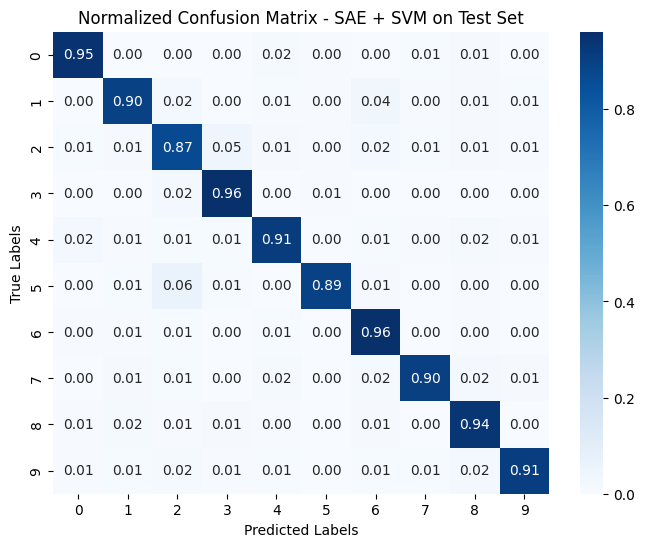

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    """Plot a normalized confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

time_train_saesvm = time.time()

# Build and compile the autoencoder
autoencoder = build_sae(64)
autoencoder.compile(optimizer='adam', loss='mse')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train on the entire training set
autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=64,
    validation_data=(x_val, x_val),
    callbacks=[early_stopping],
    verbose=1
)

# Step 2: Extract Bottleneck Features
train_features = extract_features(autoencoder, x_train)
test_features = extract_features(autoencoder, x_test)

# Step 3: Scale the Features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Step 4: Train the SVM Classifier on the Extracted Features
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_classifier.fit(train_features_scaled, y_train)

# Step 5: Evaluate on the Test Set
test_predictions = svm_classifier.predict(test_features_scaled)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"\nSAE + SVM Test Accuracy: {test_accuracy:.4f}")
log_time("Train SAE+SVM time", time_train_saesvm)

# Step 6: Confusion Matrix and Classification Report
cm = confusion_matrix(y_test, test_predictions, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
plt.title("Normalized Confusion Matrix - SAE + SVM on Test Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [15]:
sae_total_params = autoencoder.count_params()
print(f"Total parameters in SAE model: {sae_total_params}")

Total parameters in SAE model: 1602848


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


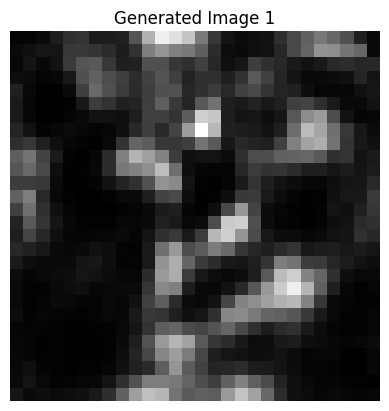

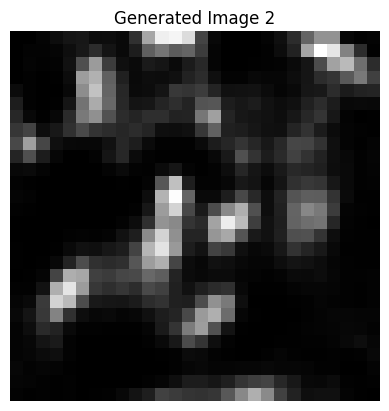

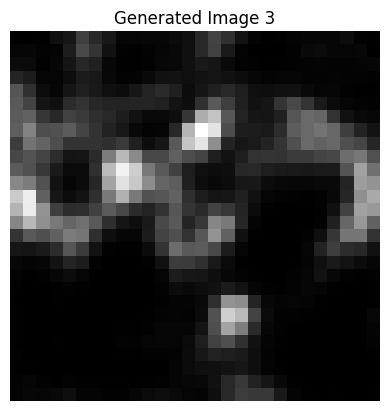

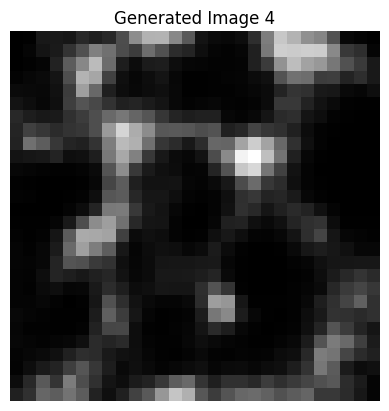

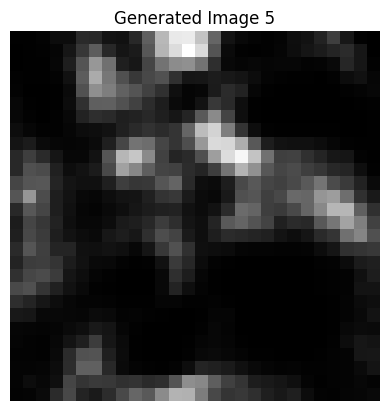

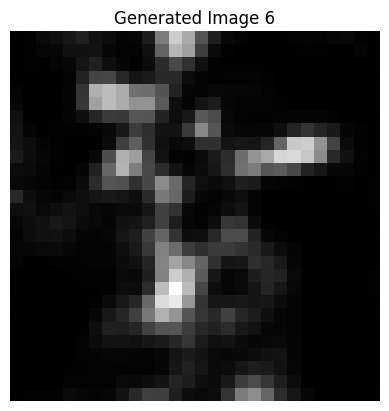

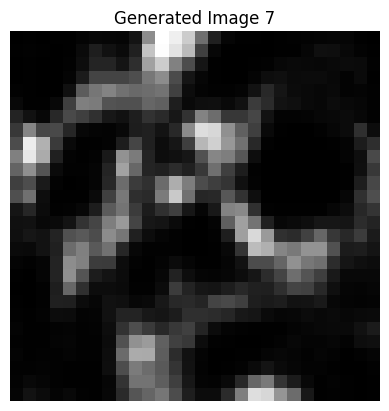

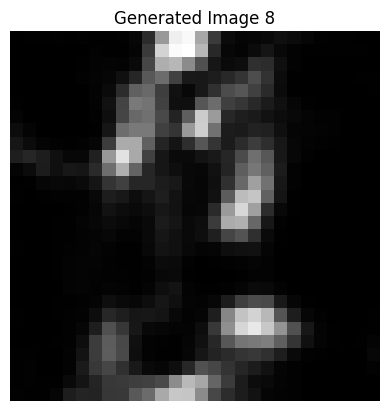

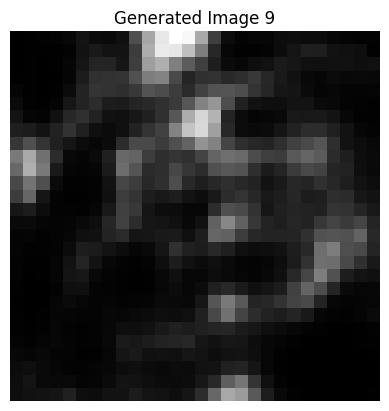

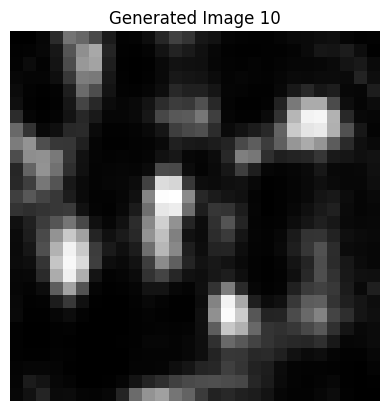

In [16]:
# Extract the decoder from the trained autoencoder
def extract_decoder(autoencoder):
    """
    Extracts the decoder from the trained autoencoder.
    """
    # Define the bottleneck layer input manually
    bottleneck_dim = autoencoder.get_layer('bottleneck').units  # Get the number of units in bottleneck layer
    decoder_input = Input(shape=(bottleneck_dim,), name="decoder_input")

    # Connect the decoder layers to the bottleneck input
    decoder_output = autoencoder.get_layer('decoder_1')(decoder_input)
    decoder_output = autoencoder.get_layer('decoder_2')(decoder_output)
    decoder_output = autoencoder.get_layer('output_layer')(decoder_output)

    # Create the decoder model
    decoder = Model(inputs=decoder_input, outputs=decoder_output, name="decoder")
    return decoder

# Extract the trained decoder
decoder = extract_decoder(autoencoder)

# Generate bottleneck codes
num_images = 10  # Number of images to generate
bottleneck_size = autoencoder.get_layer('bottleneck').units  # Automatically determine bottleneck size
bottleneck_codes = np.random.normal(0, 1, size=(num_images, bottleneck_size))  # Random latent codes

# Use the decoder to generate images
generated_images = decoder.predict(bottleneck_codes)

# Visualize the generated images
for i in range(num_images):
    plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')  # Reshape to 28x28 if input size is 784
    plt.title(f"Generated Image {i+1}")
    plt.axis('off')
    plt.show()

In [17]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Extract representative codes for each class
def extract_representative_codes(autoencoder, x_train, y_train):
    """
    Extract one representative bottleneck code for each class.
    """
    bottleneck_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('bottleneck').output)
    representative_codes = []
    for class_label in np.unique(y_train):
        class_indices = np.where(y_train == class_label)[0]
        # Take the first sample from each class
        representative_code = bottleneck_model.predict(x_train[class_indices[:1]], verbose=0)[0]
        representative_codes.append(representative_code)
    return np.array(representative_codes)

# Step 2: Add Gaussian noise to bottleneck codes
def generate_noisy_images(decoder, representative_codes, num_images=1000, noise_variances=[0.1, 0.2, 0.3]):
    """
    Generate images by adding Gaussian noise to the bottleneck codes.
    """
    num_classes = len(representative_codes)
    images_per_class = num_images // num_classes
    augmented_images = []
    augmented_labels = []

    for variance in noise_variances:
        for class_idx, code in enumerate(representative_codes):
            for _ in range(images_per_class // len(noise_variances)):
                noisy_code = code + np.random.normal(0, variance, size=code.shape)
                generated_image = decoder.predict(np.expand_dims(noisy_code, axis=0), verbose=0)[0]
                augmented_images.append(generated_image)
                augmented_labels.append(class_idx)

    return np.array(augmented_images), np.array(augmented_labels)

# Step 3: Generate and visualize images
# Extract the trained decoder
decoder = extract_decoder(autoencoder)

# Extract representative codes for each class
representative_codes = extract_representative_codes(autoencoder, x_train, y_train)

# Generate 1,000 noisy images
noise_variances = [0.1, 0.2, 0.3]
augmented_images, augmented_labels = generate_noisy_images(decoder, representative_codes, num_images=1000, noise_variances=noise_variances)





Epoch 1/50
953/953 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0684 - val_loss: 0.0327
Epoch 2/50
953/953 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0258 - val_loss: 0.0258
Epoch 3/50
953/953 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0211 - val_loss: 0.0232
Epoch 4/50
953/953 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0188 - val_loss: 0.0220
Epoch 5/50
953/953 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0175 - val_loss: 0.0211
Epoch 6/50
953/953 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0166 - val_loss: 0.0208
Epoch 7/50
953/953 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0159 - val_loss: 0.0198
Epoch 8/50
953/953 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0156 - val_loss: 0.0199
Epoch 9/50
953/953 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0153 - val_loss: 0.0192
Epoch 10/50
953/953 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0150 - val_loss: 0.0192
Epoch 11/50
953/953 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0147 - val_loss: 0.0196
Epoch 12/50
953/953 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

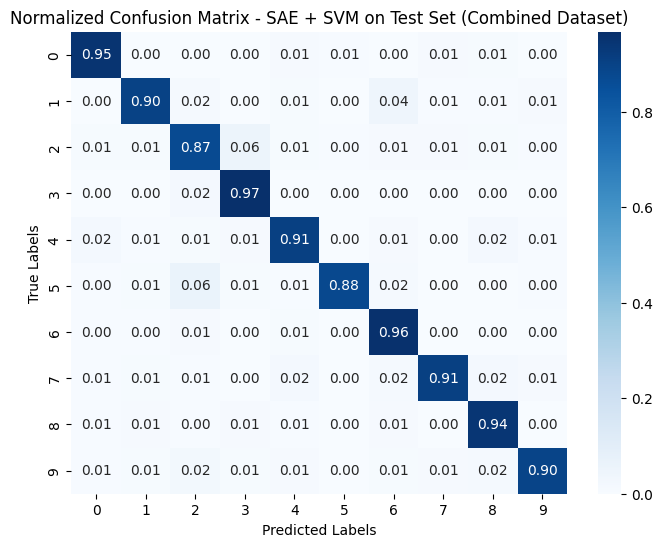

In [18]:
# Combine original and newly generated data
combined_train_images = np.vstack([x_train, augmented_images])  # Combine original and generated images
combined_train_labels = np.hstack([y_train, augmented_labels])  # Combine corresponding labels

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 1: Train the autoencoder on the combined training dataset

autoencoder_augmented = build_sae(64)
autoencoder_augmented.compile(optimizer='adam', loss='mse')


start_time = time.time()
autoencoder_augmented.fit(
    combined_train_images, combined_train_images,  # Train on combined dataset
    epochs=50,
    batch_size=64,
    validation_data=(x_val, x_val),
    callbacks=[early_stopping],
    verbose=1
)
training_time = time.time() - start_time
print(f"Training Time (Combined Dataset): {training_time:.2f} seconds")

# Step 2: Extract Bottleneck Features
train_features_combined = extract_features(autoencoder_augmented, combined_train_images)
test_features_combined = extract_features(autoencoder_augmented, x_test)

# Step 3: Scale the Features
scaler = StandardScaler()
train_features_scaled_combined = scaler.fit_transform(train_features_combined)
test_features_scaled_combined = scaler.transform(test_features_combined)

# Step 4: Train the SVM Classifier on the Combined Dataset
start_time_svm = time.time()
svm_classifier_combined = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_classifier_combined.fit(train_features_scaled_combined, combined_train_labels)
svm_training_time = time.time() - start_time_svm

# Step 5: Evaluate on the Test Set
test_predictions_combined = svm_classifier_combined.predict(test_features_scaled_combined)
test_accuracy_combined = accuracy_score(y_test, test_predictions_combined)

print(f"\nSAE + SVM Test Accuracy (Combined Dataset): {test_accuracy_combined:.4f}")
print(f"SVM Training Time (Combined Dataset): {svm_training_time:.2f} seconds")

# Step 6: Generate Confusion Matrix and Classification Report
cm_combined = confusion_matrix(y_test, test_predictions_combined, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm_combined, annot=True, cmap='Blues', fmt='.2f')
plt.title("Normalized Confusion Matrix - SAE + SVM on Test Set (Combined Dataset)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
953/953 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6710 - loss: 0.9793 - val_accuracy: 0.7783 - val_loss: 0.7090
Epoch 2/100
953/953 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9101 - loss: 0.2871 - val_accuracy: 0.8376 - val_loss: 0.5377
Epoch 3/100
953/953 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9433 - loss: 0.1826 - val_accuracy: 0.8699 - val_loss: 0.4519
Epoch 4/100
953/953 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9622 - loss: 0.1228 - val_accuracy: 0.8796 - val_loss: 0.4523
Epoch 5/100
953/953 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9731 - loss: 0.0847 - val_accuracy: 0.8765 - val_loss: 0.4825
Epoch 6/100
953/953 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9825 - loss: 0.0575 - val_accuracy: 0.8730 - val_loss: 0.5515
Epoch 7/100
953/953 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9853 - loss: 0.0453 - val_accuracy: 0.8769 - val_loss: 0.5678
Epoch 8/100
953/953 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9881 - loss: 0.0375 - val_accu

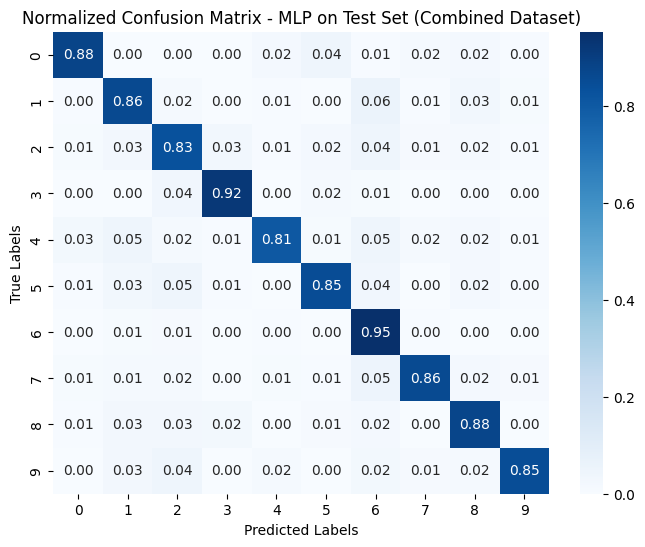

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt




x_test_processed = test_images.reshape(test_images.shape[0], -1) / 255.0  # Process test data similarly

# One-hot encode the labels
y_train_augmented_one_hot = tf.one_hot(combined_train_labels, depth=10)
test_labels_one_hot = tf.one_hot(test_labels, depth=10)
val_labels_one_hot = tf.one_hot(y_val, depth=10)

# Define the MLP model
num_layers = 3
num_units = 512
learning_rate = 0.001
patience = 7

time_augmented_MLP = time.time()

model = Sequential([Flatten(input_shape=(28 * 28,))])  # Input shape matches the flattened image dimensions
for _ in range(num_layers):
    model.add(Dense(num_units, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))  # Output layer for 10 classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)


start_time = time.time()
# Train the MLP with augmented data
history = model.fit(combined_train_images, y_train_augmented_one_hot, epochs=100,
                    validation_data=(x_val, val_labels_one_hot),
                    batch_size=64, callbacks=[early_stopping], verbose=1)
training_time = time.time() - start_time
print(f"MLP Training Time (Combined Dataset): {training_time:.2f} seconds")


# Evaluate the model
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = test_labels  # Keep test labels as integers for confusion matrix

# Calculate accuracy
test_accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate normalized confusion matrix
cm_combined_mlp = confusion_matrix(y_true, y_pred_classes, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm_combined_mlp, annot=True, cmap='Blues', fmt='.2f')
plt.title("Normalized Confusion Matrix - MLP on Test Set (Combined Dataset)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Training SAE with bottleneck size 16
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


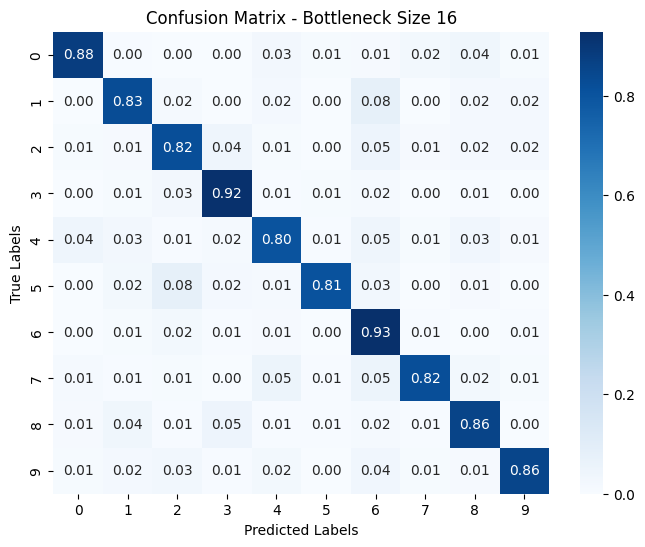

Bottleneck size 16 - Test Accuracy: 0.8529
Training SAE with bottleneck size 32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


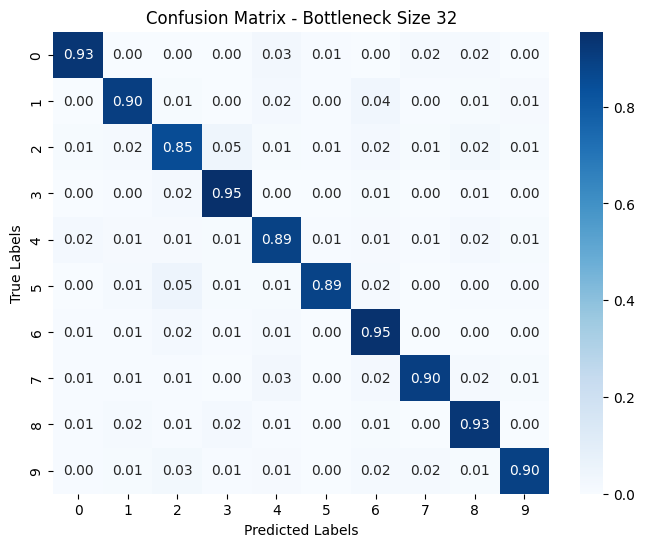

Bottleneck size 32 - Test Accuracy: 0.9080
Training SAE with bottleneck size 64
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


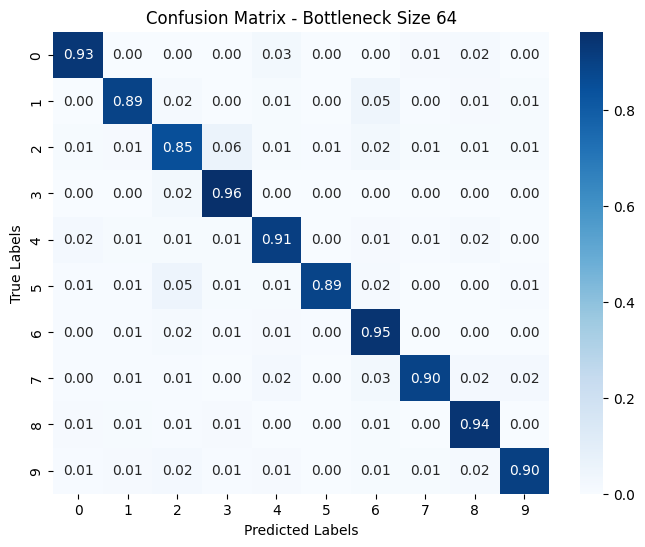

Bottleneck size 64 - Test Accuracy: 0.9131
Training SAE with bottleneck size 128
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


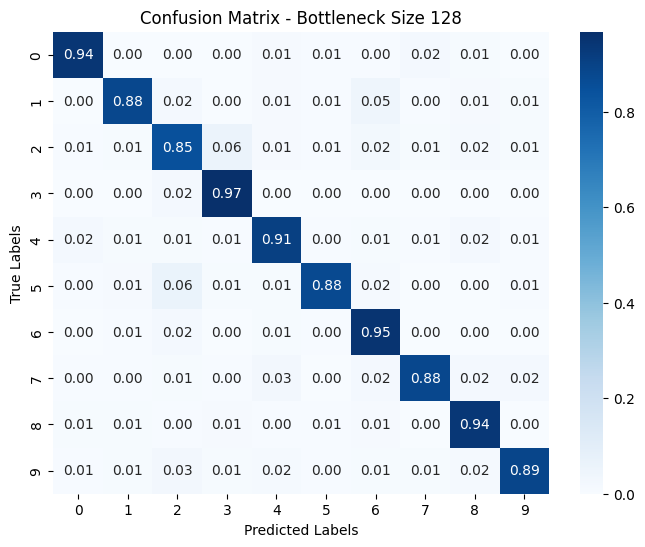

Bottleneck size 128 - Test Accuracy: 0.9096
Training SAE with bottleneck size 256
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


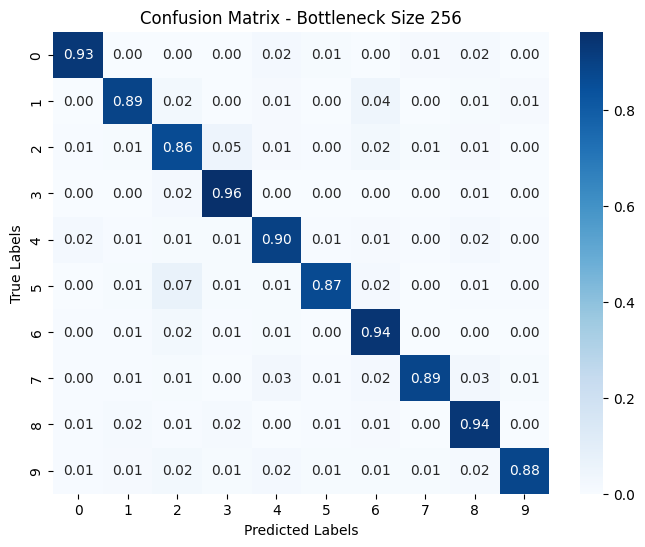

Bottleneck size 256 - Test Accuracy: 0.9059
Training SAE with bottleneck size 400
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


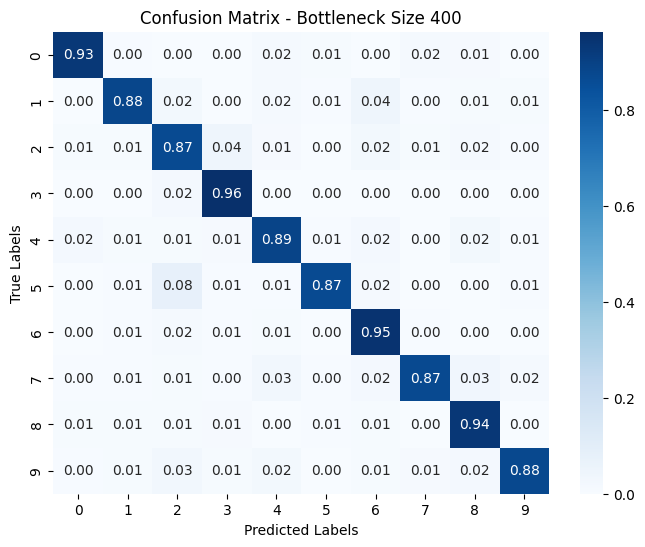

Bottleneck size 400 - Test Accuracy: 0.9037


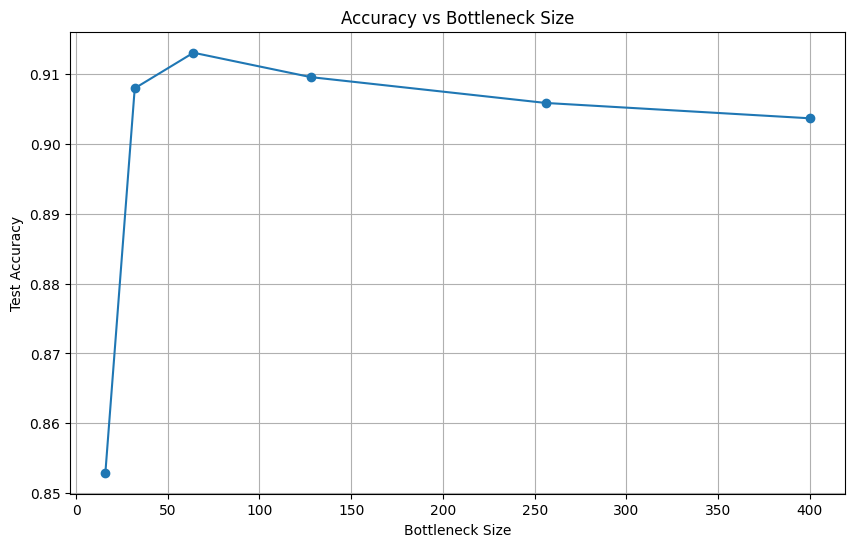

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import numpy as np


def plot_confusion_matrix(y_true, y_pred, title):
    """Plot a normalized confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Define bottleneck sizes to evaluate
bottleneck_sizes = [16, 32, 64, 128, 256, 400]
accuracies = []

for size in bottleneck_sizes:
    print(f"Training SAE with bottleneck size {size}")

    # Train the SAE with current bottleneck size
    autoencoder = build_sae(size)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(x_train, x_train, epochs=50, batch_size=64, validation_data=(x_val, x_val), verbose=0)

    # Extract features from the bottleneck layer
    train_features = extract_features(autoencoder, x_train)
    test_features = extract_features(autoencoder, x_test)

    # Scale features
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    test_features_scaled = scaler.transform(test_features)

    # Train the SVM on the extracted features
    svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale')
    svm_classifier.fit(train_features_scaled, y_train)

    # Predict on the test set
    test_predictions = svm_classifier.predict(test_features_scaled)
    accuracy = accuracy_score(y_test, test_predictions)
    accuracies.append(accuracy)

    # Plot the confusion matrix for the current bottleneck size
    plot_confusion_matrix(y_test, test_predictions, f"Confusion Matrix - Bottleneck Size {size}")
    print(f"Bottleneck size {size} - Test Accuracy: {accuracy:.4f}")

# Plot the bottleneck size vs accuracy
plt.figure(figsize=(10, 6))
plt.plot(bottleneck_sizes, accuracies, marker='o')
plt.title("Accuracy vs Bottleneck Size")
plt.xlabel("Bottleneck Size")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()


## Part 2

In [21]:
from re import X

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Flatten images for input into the SAE
x_train = train_images.reshape(-1, 784)
x_test = test_images.reshape(-1, 784)

# Split into training and validation sets
x_train, x_val, y_train, y_val = x_train, x_test,y_train,test_labels


# One-hot encode labels
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(test_labels, num_classes=10)


In [39]:
num_classes = 10
bottleneck_dim = 10  # Bottleneck size

np.random.seed(42)
targets = np.random.randn(num_classes, bottleneck_dim)
targets = targets / np.linalg.norm(targets, axis=1, keepdims=True)
targets_tensor = tf.convert_to_tensor(targets, dtype=tf.float32)


In [49]:
from sklearn.preprocessing import normalize
from tensorflow.keras.layers import Input, Dense, Layer


def generate_orthogonal_vectors(num_classes, bottleneck_dim):
    """
    Generate orthogonal vectors for the penalty layer targets.
    """
    random_matrix = np.random.randn(num_classes, bottleneck_dim)
    orthogonal_matrix, _ = np.linalg.qr(random_matrix)
    orthogonal_matrix = normalize(orthogonal_matrix, axis=1)
    return orthogonal_matrix

class PenaltyLayer(Layer):
    def __init__(self, targets, lambda_penalty, distance_metric='euclidean', p=3, **kwargs):
        super(PenaltyLayer, self).__init__(**kwargs)
        self.targets = targets
        self.lambda_penalty = lambda_penalty
        self.distance_metric = distance_metric
        self.p = p  # Minkowski parameter

    def call(self, bottleneck_outputs, labels):
        targets_batch = tf.gather(self.targets, tf.argmax(labels, axis=1))

        if self.distance_metric == 'manhattan':
            distances = tf.reduce_sum(tf.abs(bottleneck_outputs - targets_batch), axis=1)
        elif self.distance_metric == 'minkowski':
            distances = tf.reduce_sum(tf.pow(tf.abs(bottleneck_outputs - targets_batch), self.p), axis=1)
            distances = tf.pow(distances, 1.0 / self.p)
        else:  # Euclidean
            squared_diff = tf.square(bottleneck_outputs - targets_batch)
            distances = tf.sqrt(tf.reduce_sum(squared_diff, axis=1))

        penalty_R = tf.reduce_mean(distances)
        self.add_loss(self.lambda_penalty * penalty_R)
        return bottleneck_outputs


def create_custom_loss(model):
    def custom_loss(y_true, y_pred):
        reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(y_true, y_pred))
        penalty_term = sum(model.losses)
        total_loss = reconstruction_loss + penalty_term
        return total_loss
    return custom_loss

def extract_bottleneck_features(autoencoder, x_data):
    bottleneck_model = Model(inputs=autoencoder.input[0], outputs=autoencoder.get_layer('bottleneck').output)
    return bottleneck_model.predict(x_data)

def train_svm(features_train, labels_train, features_test, labels_test):
    svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
    svm_classifier.fit(features_train, labels_train)
    train_accuracy = svm_classifier.score(features_train, labels_train)
    test_accuracy = svm_classifier.score(features_test, labels_test)
    return train_accuracy, test_accuracy

In [41]:
# Generate the target sets
direct_targets = tf.convert_to_tensor(np.eye(num_classes), dtype=tf.float32)

custom_targets = np.random.randn(num_classes, bottleneck_dim)
custom_targets = custom_targets / np.linalg.norm(custom_targets, axis=1, keepdims=True)
custom_targets = tf.convert_to_tensor(custom_targets, dtype=tf.float32)

orthogonal_targets = generate_orthogonal_vectors(num_classes=num_classes, bottleneck_dim=bottleneck_dim)
orthogonal_targets_tensor = tf.convert_to_tensor(orthogonal_targets, dtype=tf.float32)


random_diagonal_matrix = np.zeros((num_classes, bottleneck_dim))
diag_length = min(num_classes, bottleneck_dim)
diagonal_values = np.random.randn(diag_length)
for i in range(diag_length):
    random_diagonal_matrix[i, i] = diagonal_values[i]
random_diagonal_targets_tensor = tf.convert_to_tensor(random_diagonal_matrix, dtype=tf.float32)


target_sets = [direct_targets, custom_targets, orthogonal_targets_tensor, random_diagonal_targets_tensor]
target_names = ["Direct Assignment", "Custom Random Vectors", "Orthogonal Vectors","diagonal_targets_tensor"]

In [42]:


def evaluate_R(x_data, y_data):
    # Get bottleneck outputs
    bottleneck_outputs = bottleneck_model.predict(x_data)  # Shape: (batch_size, bottleneck_dim)
    y_labels = np.argmax(y_data, axis=1)  # Convert one-hot to class labels, Shape: (batch_size,)
    targets_batch = tf.gather(targets_tensor, y_labels)  # Shape: (batch_size, bottleneck_dim)

    # Compute penalty R
    squared_diff = tf.square(bottleneck_outputs - targets_batch)
    distances = tf.reduce_sum(squared_diff, axis=1)
    penalty_R = tf.reduce_mean(distances)
    return penalty_R.numpy()





In [43]:

def build_sae_with_penalty(input_dim, bottleneck_dim, targets_tensor, lambda_penalty):
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(800, activation='relu')(input_layer)
    encoder = Dense(200, activation='relu')(encoder)
    bottleneck = Dense(bottleneck_dim, activation='linear', name='bottleneck')(encoder)

    labels_input = Input(shape=(num_classes,), name="labels_input")  # One-hot labels
    penalty_layer = PenaltyLayer(targets_tensor, lambda_penalty)(bottleneck, labels_input)

    decoder = Dense(200, activation='relu')(penalty_layer)
    decoder = Dense(800, activation='relu')(decoder)
    output_layer = Dense(input_dim, activation='sigmoid')(decoder)

    autoencoder = Model(inputs=[input_layer, labels_input], outputs=output_layer)
    return autoencoder

# Step 4: Train and evaluate each SAE
def train_and_evaluate(autoencoder, targets_tensor, x_train, y_train, x_test, y_test):
    autoencoder.compile(optimizer='adam', loss=create_custom_loss(autoencoder))
    autoencoder.fit([x_train, y_train], x_train, epochs=20, batch_size=64, verbose=1)
    features_train = extract_bottleneck_features(autoencoder, x_train)
    features_test = extract_bottleneck_features(autoencoder, x_test)
    return train_svm(features_train, y_train, features_test, y_test)

In [50]:
lambda_penalty = 0.1
distance_metrics = ['euclidean', 'manhattan','minkowski']
results = []

for target_idx, (targets_tensor, target_name) in enumerate(zip(target_sets, target_names)):
    for distance_metric in distance_metrics:
        print(f"\nTraining with {target_name}, Distance Metric: {distance_metric}")

        # Build SAE model with penalty layer directly included
        autoencoder = build_sae_with_penalty(
            input_dim=784,
            bottleneck_dim=10,
            targets_tensor=targets_tensor,
            lambda_penalty=lambda_penalty
        )

        # Compile and train the autoencoder
        autoencoder.compile(optimizer='adam', loss=create_custom_loss(autoencoder))
        autoencoder.fit([x_train, y_train], x_train, epochs=20, batch_size=64, verbose=1)

        # Extract bottleneck features
        train_features = extract_bottleneck_features(autoencoder, x_train)
        test_features = extract_bottleneck_features(autoencoder, x_test)

        # Prepare labels for SVM
        y_train_labels = np.argmax(y_train, axis=1)
        y_test_labels = np.argmax(y_test, axis=1)

        # Train and evaluate SVM
        train_acc, test_acc = train_svm(train_features, y_train_labels, test_features, y_test_labels)

        # Store results
        results.append({
            'Target Method': target_name,
            'Distance Metric': distance_metric,
            'Train Accuracy': train_acc,
            'Test Accuracy': test_acc
        })



Training with Direct Assignment, Distance Metric: euclidean
Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1939
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1217
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1054
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0956
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0886
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0834
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0795
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0766
Epoch 9/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0744
Epoch 10/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0721
Epoch 11/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0706
Epoch 12/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0694
Epoch 13/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0680
Epoch 14/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0

In [51]:
import pandas as pd
import seaborn as sns

results_df = pd.DataFrame(results)
print(results_df)


              Target Method Distance Metric  Train Accuracy  Test Accuracy
0         Direct Assignment       euclidean        0.993967         0.9007
1         Direct Assignment       manhattan        0.991983         0.8962
2         Direct Assignment       minkowski        0.992250         0.9000
3     Custom Random Vectors       euclidean        0.993133         0.8956
4     Custom Random Vectors       manhattan        0.993033         0.8991
5     Custom Random Vectors       minkowski        0.993967         0.9049
6        Orthogonal Vectors       euclidean        0.992367         0.9003
7        Orthogonal Vectors       manhattan        0.990683         0.8947
8        Orthogonal Vectors       minkowski        0.992600         0.8970
9   diagonal_targets_tensor       euclidean        0.982417         0.8693
10  diagonal_targets_tensor       manhattan        0.982733         0.8717
11  diagonal_targets_tensor       minkowski        0.983133         0.8734


In [58]:
def generate_target_sets(num_classes, bottleneck_dim, num_sets):
    target_sets = []
    for _ in range(num_sets):
        targets = np.random.randn(num_classes, bottleneck_dim)
        targets = targets / np.linalg.norm(targets, axis=1, keepdims=True)
        target_sets.append(tf.convert_to_tensor(targets, dtype=tf.float32))
    return target_sets

# Generate 5 different target sets
num_target_sets = 3
target_sets = generate_target_sets(num_classes=10, bottleneck_dim=64, num_sets=num_target_sets)


In [59]:
# Define lambda values
lambda_values = [0.001, 0.01, 0.1, 0.2, 0.4, 0.8, 1]

# Results storage
results_3d = []

# Loop through each target set and lambda value
for target_index, targets_tensor in enumerate(target_sets):
    for lambda_penalty in lambda_values:
        print(f"\nTraining with Target Set {target_index + 1}, Lambda={lambda_penalty}, Distance=Minkowski...")

        # Define the input layers
        input_layer = Input(shape=(784,), name="input_layer")
        labels_input = Input(shape=(num_classes,), name="labels_input")

        # Build the SAE with the current target set and lambda
        encoder = Dense(800, activation='relu')(input_layer)
        encoder = Dense(200, activation='relu')(encoder)
        bottleneck = Dense(64, activation='linear', name='bottleneck')(encoder)

        penalty_layer = PenaltyLayer(
            targets=targets_tensor,
            lambda_penalty=lambda_penalty,
            distance_metric='minkowski',
            p=3
        )(bottleneck, labels_input)

        decoder = Dense(200, activation='relu')(penalty_layer)
        decoder = Dense(800, activation='relu')(decoder)
        output_layer = Dense(784, activation='sigmoid')(decoder)

        autoencoder = Model(inputs=[input_layer, labels_input], outputs=output_layer)
        autoencoder.compile(optimizer='adam', loss=create_custom_loss(autoencoder))

        # Train the SAE
        autoencoder.fit(
            [x_train, y_train], x_train,
            validation_data=([x_val, y_val], x_val),
            epochs=25,
            batch_size=64,
            callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
            verbose=0
        )

        # Extract bottleneck features for validation set
        bottleneck_model = Model(inputs=autoencoder.input[0], outputs=autoencoder.get_layer('bottleneck').output)
        latent_val = bottleneck_model.predict(x_val)

        # Evaluate penalty R on validation set
        penalty_R = evaluate_R(x_val, y_val)

        # Train and evaluate SVM accuracy on the extracted bottleneck features
        svm = SVC(kernel='linear', C=1.0)
        svm.fit(latent_val, np.argmax(y_val, axis=1))
        val_acc = svm.score(latent_val, np.argmax(y_val, axis=1))

        # Store the results
        results_3d.append({
            'target_set': target_index + 1,
            'lambda': lambda_penalty,
            'penalty_R': penalty_R,
            'accuracy': val_acc
        })

        print(f"Penalty R: {penalty_R:.4f}, Accuracy: {val_acc:.4f}")



Training with Target Set 1, Lambda=0.001, Distance=Minkowski...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Penalty R: 1.7636, Accuracy: 0.8078

Training with Target Set 1, Lambda=0.01, Distance=Minkowski...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Penalty R: 0.3120, Accuracy: 0.8770

Training with Target Set 1, Lambda=0.1, Distance=Minkowski...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Penalty R: 0.1952, Accuracy: 0.8950

Training with Target Set 1, Lambda=0.2, Distance=Minkowski...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Penalty R: 0.1888, Accuracy: 0.9008

Training with Target Set 1, Lambda=0.4, Distance=Minkowski...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Penalty R: 0.1817, Accuracy: 0.9016

Training with Target Set 1, Lambda=0.8, Distance=Minkowski...
313/313 ━━━━━━━━━━━━━━━━━━━━ 

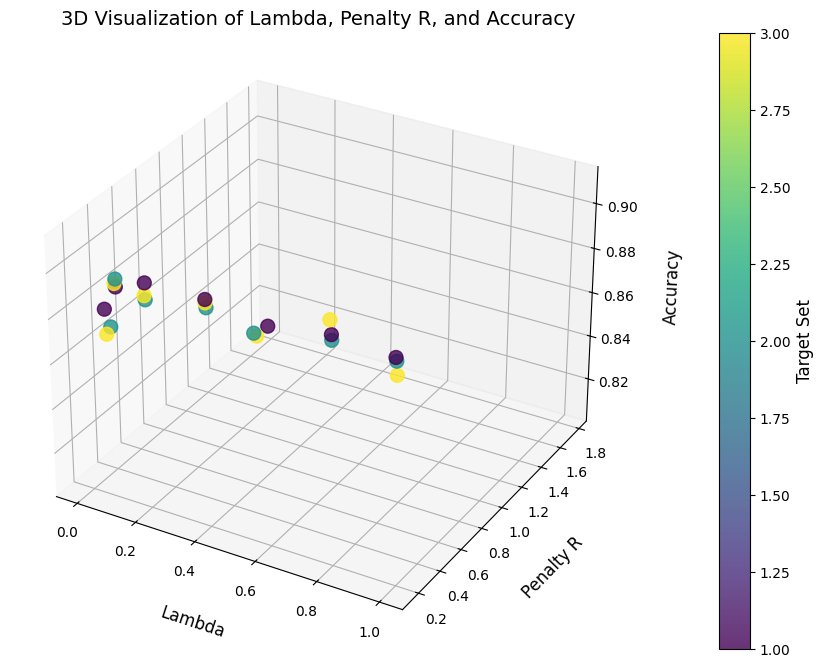

In [62]:
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# Assuming results_3d is already defined and contains the results
results_df = pd.DataFrame(results_3d)

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    results_df['lambda'],
    results_df['penalty_R'],
    results_df['accuracy'],
    c=results_df['target_set'],  # Color by target set
    cmap='viridis',
    s=100,
    alpha=0.8
)

# Add a color bar for the target sets
cbar = plt.colorbar(scatter, pad=0.1)
cbar.set_label('Target Set', fontsize=12)

# Set axis labels and title
ax.set_xlabel('Lambda', labelpad=15, fontsize=12)
ax.set_ylabel('Penalty R', labelpad=15, fontsize=12)
ax.set_zlabel('Accuracy', labelpad=15, fontsize=12)
ax.set_title('3D Visualization of Lambda, Penalty R, and Accuracy', fontsize=14)

# Adjust tick label sizes
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='z', labelsize=10)

# Add grid for better visualization
ax.grid(True)

# Show the plot
plt.show()





In [64]:

num_classes = 10
bottleneck_dim = 64  # Bottleneck size
np.random.seed(42)

# Generate random target vectors of size 64 for each class
targets = np.random.randn(num_classes, bottleneck_dim)
targets = targets / np.linalg.norm(targets, axis=1, keepdims=True)  # Normalize to unit length
targets_tensor = tf.convert_to_tensor(targets, dtype=tf.float32)


Training with batch size: 64
Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.6595 - val_loss: 0.4432
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.3050 - val_loss: 0.3912
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2598 - val_loss: 0.3718
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2362 - val_loss: 0.3596
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2200 - val_loss: 0.3528
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2077 - val_loss: 0.3476
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1968 - val_loss: 0.3374
Epoch 8/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1895 - val_loss: 0.3401
Epoch 9/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1812 - val_loss: 0.3304
Epoch 10/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1761 - val_loss: 0.3327
Epoch 11/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1705 - val_loss: 0.3305
Epoch 12/50
938/938 ━━

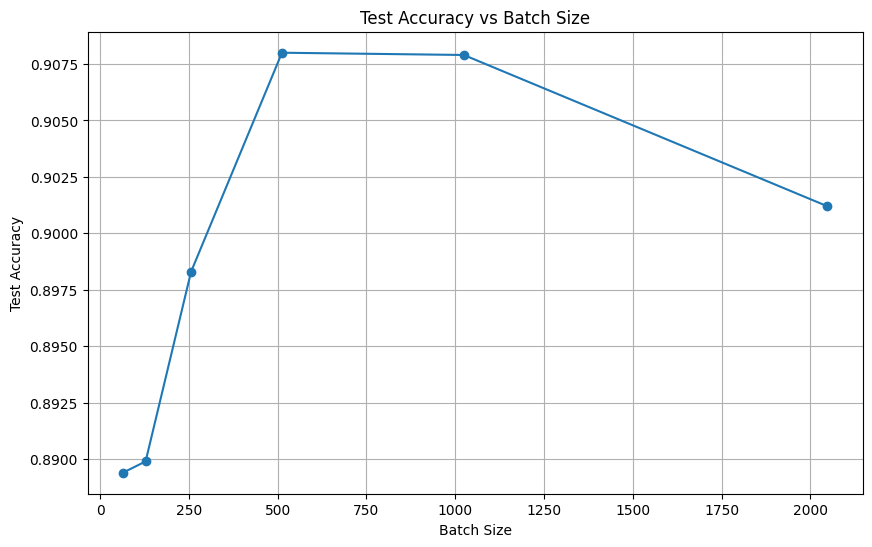

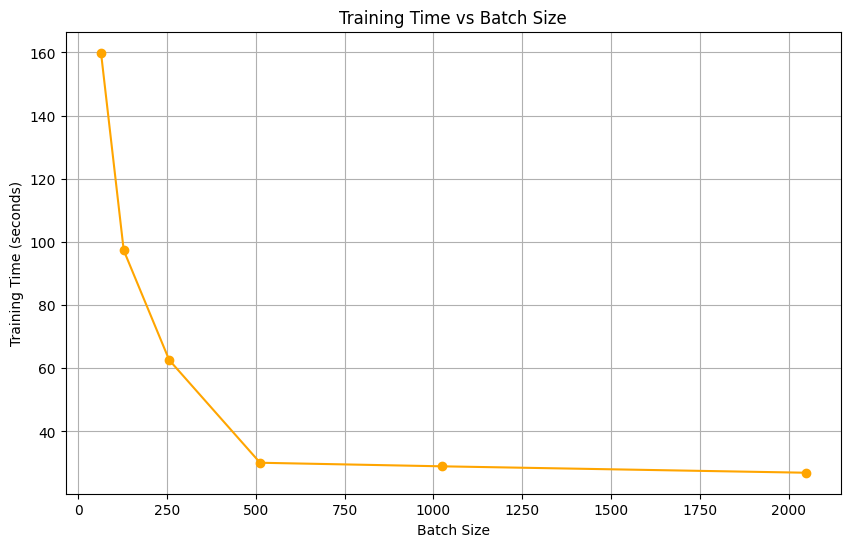

In [67]:
from inspect import EndOfBlock
def build_sae_with_penalty_final(bottleneck_dim, targets_tensor, lambda_penalty, input_dim=784, num_classes=10):

    # Encoder
    input_layer = Input(shape=(input_dim,), name="input_layer")
    encoder = Dense(800, activation='relu', name="encoder_1")(input_layer)
    encoder = Dense(200, activation='relu', name="encoder_2")(encoder)
    bottleneck = Dense(bottleneck_dim, activation='linear', name="bottleneck")(encoder)

    # Penalty Layer
    labels_input = Input(shape=(num_classes,), name="labels_input")  # One-hot labels
    penalty_layer = PenaltyLayer(
            targets=targets_tensor,
            lambda_penalty=lambda_penalty,
            distance_metric='minkowski',
            p=3
        )(bottleneck, labels_input)


    # Decoder
    decoder = Dense(200, activation='relu', name="decoder_1")(penalty_layer)
    decoder = Dense(800, activation='relu', name="decoder_2")(decoder)
    output_layer = Dense(input_dim, activation='sigmoid', name="output_layer")(decoder)

    # Build the model
    autoencoder = Model(inputs=[input_layer, labels_input], outputs=output_layer, name="SAE_with_Penalty")
    return autoencoder


def extract_features_with_penalty(autoencoder, x_data, y_data):

    bottleneck_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('bottleneck').output)
    bottleneck_features = bottleneck_model.predict([x_data, y_data])
    return bottleneck_features



# Define the batch sizes to test
batch_sizes = [64, 128, 256, 512,1024,2048]

# Store results
batch_size_results = []

for batch_size in batch_sizes:
    print(f"\nTraining with batch size: {batch_size}")

    # Define and compile the model
    autoencoder_with_penalty = build_sae_with_penalty_final(
        bottleneck_dim=64,
        lambda_penalty=0.8,
        targets_tensor=targets_tensor
    )
    autoencoder_with_penalty.compile(
        optimizer='adam',
        loss=create_custom_loss(autoencoder_with_penalty)
    )

    # Train the autoencoder
    start_time = time.time()
    history = autoencoder_with_penalty.fit(
        [x_train, y_train], x_train,
        epochs=50,
        batch_size=batch_size,
        validation_data=([x_val, y_val], x_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
        verbose=1
    )
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Extract bottleneck features
    train_features_penalty = extract_features_with_penalty(autoencoder_with_penalty, x_train, y_train)
    test_features_penalty = extract_features_with_penalty(autoencoder_with_penalty, x_test, y_test)

    # Normalize features
    scaler = StandardScaler()
    train_features_scaled_penalty = scaler.fit_transform(train_features_penalty)
    test_features_scaled_penalty = scaler.transform(test_features_penalty)

    # Train SVM classifier
    svm_classifier_penalty = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
    svm_classifier_penalty.fit(train_features_scaled_penalty, np.argmax(y_train, axis=1))

    # Evaluate SVM
    test_predictions_penalty = svm_classifier_penalty.predict(test_features_scaled_penalty)
    test_accuracy_penalty = accuracy_score(np.argmax(y_test, axis=1), test_predictions_penalty)

    # Store results
    batch_size_results.append({
        "batch_size": batch_size,
        "test_accuracy": test_accuracy_penalty,
        "elapsed_time": elapsed_time
    })
    print(f"Batch size: {batch_size}, Test Accuracy: {test_accuracy_penalty:.4f}, Training Time: {elapsed_time:.2f} seconds")

# Display results as a DataFrame
import pandas as pd
results_df = pd.DataFrame(batch_size_results)
print("\nBatch Size Results:")
print(results_df)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results_df['batch_size'], results_df['test_accuracy'], marker='o')
plt.title('Test Accuracy vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(results_df['batch_size'], results_df['elapsed_time'], marker='o', color='orange')
plt.title('Training Time vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Training Time (seconds)')
plt.grid(True)
plt.show()



In [68]:
# Define SAE architecture with Penalty Layer
autoencoder_with_penalty = build_sae_with_penalty_final(
    bottleneck_dim=64,
    lambda_penalty=0.8,
    targets_tensor=targets_tensor
)

# Compile the autoencoder with a custom loss function
autoencoder_with_penalty.compile(
    optimizer='adam',
    loss=create_custom_loss(autoencoder_with_penalty)
)

# Train the autoencoder with batch size 512
batch_size = 512

start_time = time.time()
history = autoencoder_with_penalty.fit(
    [x_train, y_train], x_train,
    epochs=50,
    batch_size=batch_size,
    validation_data=([x_val, y_val], x_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)
end_time = time.time()
elapsed_time = end_time - start_time

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 1.0820 - val_loss: 0.6494
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4584 - val_loss: 0.4926
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3405 - val_loss: 0.4331
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2963 - val_loss: 0.4100
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2715 - val_loss: 0.3882
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2546 - val_loss: 0.3795
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2414 - val_loss: 0.3743
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2332 - val_loss: 0.3658
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2242 - val_loss: 0.3630
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2171 - val_loss: 0.3652
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2075 - val_loss: 0.3606
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/ste

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

SAE + SVM Test Accuracy with Penalty: 0.9076
Train SAE+SVM with Penalty time: 20.59 seconds


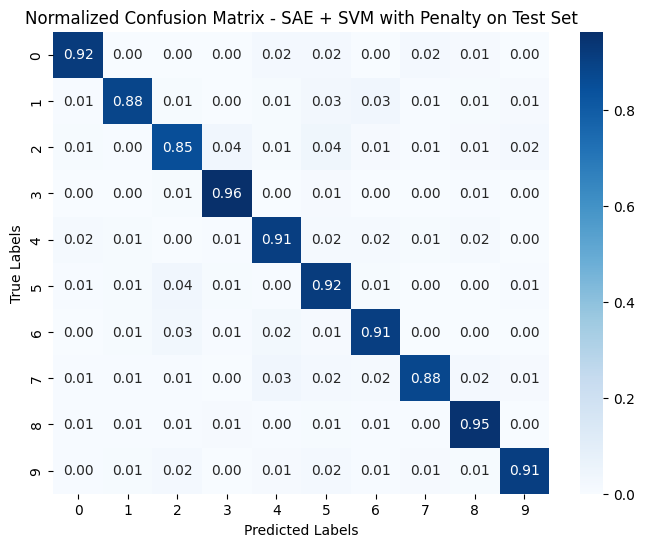

In [69]:

train_features_penalty = extract_features_with_penalty(autoencoder_with_penalty, x_train, y_train)
test_features_penalty = extract_features_with_penalty(autoencoder_with_penalty, x_test, y_test)

scaler = StandardScaler()
train_features_scaled_penalty = scaler.fit_transform(train_features_penalty)
test_features_scaled_penalty = scaler.transform(test_features_penalty)


y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Step 4: Train an SVM Classifier on Extracted Features
svm_classifier_penalty = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_classifier_penalty.fit(train_features_scaled_penalty, y_train_labels)

# Step 5: Evaluate SVM on Test Data
test_predictions_penalty = svm_classifier_penalty.predict(test_features_scaled_penalty)
test_accuracy_penalty = accuracy_score(y_test_labels, test_predictions_penalty)

print(f"\nSAE + SVM Test Accuracy with Penalty: {test_accuracy_penalty:.4f}")
print(f"Train SAE+SVM with Penalty time: {elapsed_time:.2f} seconds")

# Step 6: Generate a Confusion Matrix
cm_penalty = confusion_matrix(y_test_labels, test_predictions_penalty, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm_penalty, annot=True, cmap='Blues', fmt='.2f')
plt.title("Normalized Confusion Matrix - SAE + SVM with Penalty on Test Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
 y_test_labels

array([2, 9, 3, ..., 9, 4, 2])

In [ ]:
test_predictions_penalty

array([2, 9, 3, ..., 9, 5, 5])